# **Demo using CVAE on CORE2 data**
This is based on an example from Keras.io by fchollet.  Please see last cell for original code and links.

# Conda env Setup
The following is the list steps needed to be taken in order to set up a correct conda environment for running this notebook.

**Create Environment:**
```bash
source ~/pw/.miniconda3c/etc/profile.d/conda.sh
conda create --name NAME python=3.9
conda activate NAME
```

**Install Pacakages:** 

The following packages need to be installed on top of a typical base Conda env. Install the packages in the following order so the environment solves correctly:
```bash
conda install -y -c conda-forge tensorflow
conda install -y -c conda-forge netCDF4          # For reading nc files
conda install -y -c conda-forge cartopy          # For making maps
conda install -y -c conda-forge matplotlib
conda install -y -c conda-forge pandas
conda install -y -c conda-forge scikit-learn
conda install -y -c conda-forge cdo              # For converting grib to nc
```
**Connect Notebook to Environment:**
```bash
conda install -y ipykernel
conda install -y requests
conda install -y -c anaconda jinja2
```

# Libraries and Setup

In [1]:
import os, json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4
import cartopy

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-07-02 19:51:27.440283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 19:51:27.556897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 19:51:27.556954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 19:51:27.558803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 19:51:27.566165: I tensorflow/core/platform/cpu_feature_gua

TF version: 2.16.2
GPU is available


In [2]:
# make needed directories
!mkdir gefs_data
!mkdir gefs_data/converted

data_prefix = "./gefs_data"
data_dir = "/home/lobielodan/parsl_mpi/run_on_cluster/cvae-weather-ensemble/gefs_data/converted/" # change to match your own directory

mkdir: cannot create directory ‘gefs_data’: File exists
mkdir: cannot create directory ‘gefs_data/converted’: File exists


# Download and Convert Data
On my [first Google hit for GEFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-ensemble-forecast), I clicked on [AWS Open Data Registry for GEFS](https://registry.opendata.aws/noaa-gefs-pds/) and selected [NOAA GEFS Re-forecast](https://registry.opendata.aws/noaa-gefs-reforecast/) which has no useage restrictions.  The [GEFS Re-forecast data documentation](https://noaa-gefs-retrospective.s3.amazonaws.com/Description_of_reforecast_data.pdf) is very clear and we're going to download two files, 57 MB each.  The date of the initialization of the re-forecast is in the file name in the format YYYYMMDDHH.  The c00, p01, p02, p03, p04 are the control and perturbation ensemble members (5 total).

In [3]:
# data download
def get_data(year, month, day, times, ensembles):
    num_files = 0
    
    for time in times:
        for ensemble in ensembles:
            if f'pres_msl_{year}{month}{day}{time}_{ensemble}.grib2' not in os.listdir(data_prefix):
                !wget -q -P {data_prefix} https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/{year}/{year}{month}{day}{time}/{ensemble}/Days%3A1-10/pres_msl_{year}{month}{day}{time}_{ensemble}.grib2
                num_files += 1
            
    return num_files

In [4]:
# delete all files
def remove_data():
    !find {data_prefix} -type f -delete

## Examples:

In [5]:
# example for getting and converting files -> change the lists to fit your needs
years = ["2018"]
months = ["01"] 
days = ["01"] # forecasts are 10 days long, so (01, 10, 20) provides converage of whole year.
times = ["00"] # every six hours ("00", "06", "12", "18", "24")
ensembles = ["c00", "p01"]

for year in years:
    for month in months:
        for day in days:
            num_files = get_data(year, month, day, times, ensembles)

!csh batch_grib2nc.csh

Working on ./gefs_data/pres_msl_2018010100_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.77s 84MB]
Working on ./gefs_data/pres_msl_2018010100_p01.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.79s 84MB]


In [7]:
# example for loading data
dataset = netCDF4.Dataset(data_dir + "pres_msl_2018010100_c00.nc")
dataset2 = netCDF4.Dataset(data_dir + "pres_msl_2018010100_p01.nc")

In [8]:
# example for simple data access
print(dataset) # look at data structure
print(dataset.variables.keys())

for var in dataset.variables:
    print(dataset.variables[var])
    # print(dataset.variables[var][:]) # prints actual data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 2.4.1 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Tue Jul 02 19:52:39 2024: cdo -f nc copy ./gefs_data/pres_msl_2018010100_c00.grib2 ./gefs_data/converted/pres_msl_2018010100_c00.nc
    CDO: Climate Data Operators version 2.4.1 (https://mpimet.mpg.de/cdo)
    dimensions(sizes): time(80), lon(1440), lat(721)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), float32 msl(time, lat, lon)
    groups: 
dict_keys(['time', 'lon', 'lat', 'msl'])
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 2018-1-1 00:00:00
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (80,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    l

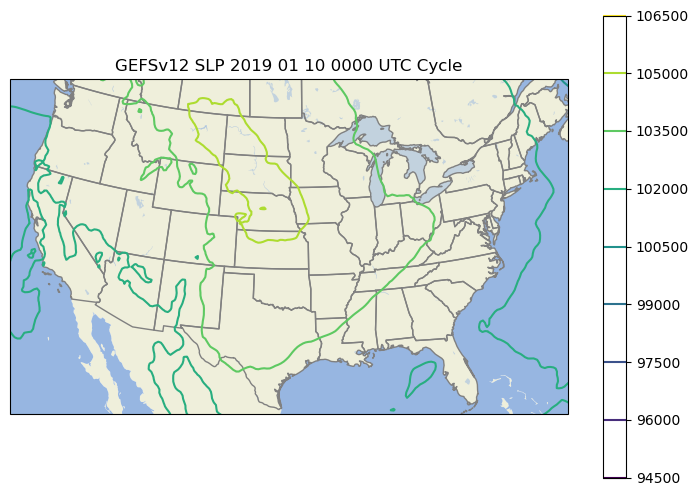

In [9]:
# example for plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')
ax.set_extent([-120, -73, 23, 50])

plt.contour(
    dataset.variables['lon'][:],     # longitudes
    dataset.variables['lat'][:],     # latitudes
    dataset.variables['msl'][0,:,:], # actual data
    transform = cartopy.crs.PlateCarree()) #, levels=np.arange(30000,110000,20000))

plt.title('GEFSv12 SLP 2019 01 10 0000 UTC Cycle')
plt.colorbar()
plt.show()

# Neural Network Design

We need to get to a small latent space. Conv2D networks are good because they help reduce the number of connections in a network in a meaningful way.  I'm using terms as defined in [this definition of conv2D](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148).

**Definitions:**
K -> kernel size;
P -> padding;
S -> stride;
D -> Dilation;
G -> Groups

**Filter options:**
Longitude is easy because it is large and even, so as long as you have an even stride, you get integer results when dividing.
e.g. lon 9: stride 4, lat 7: stride 5

- Latitude - whole numbers occurr for P = 2 & K = 3 or K = 11.
- 11 grid points * 0.25 deg * 100 km/deg = 275 km filter window (a good scale for weather)
- 9 grid points * 0.25 deg * 100 km/deg = 225 km
- Longitude - whole numbers occur for P = 0 & K = 11 (nice match with Latitude), P = 1 & K = 3 or 13, P = 2 & K = 5.

For a 5 x 7 filter with 3 stride (no overlap) and no padding:
- lat: (721 - 4) / 3 = 239 possible steps (good whole number!)
- lon: (1440 - 4) / 3 = 478.6666 possible steps

In [ ]:
# Try different filter sizes
# Aim for large initial filter > 200km scale (about 10)
# Aim for some, but minimal overlap in initial filter.

# Aim for smallish second filter, but still try to reduce dimensionality
# to make dense network tractable later. No overlap (but no good
# reason why this is).

# ----------------------Input: 721 x 1440--------------

# For Lat = 721,
# K = 11 -> K_radius = 5.0 -> S = 9 -> H_out = 79.0

# For Lon = 1440,
# K = 11 -> K_radius = 5.0 -> S = 10 -> H_out = 143.0

# -----------------------Layer1: 79 x 143----------------

# For Lat = 79,
# K = 5 -> K_radius = 2.0 -> S = 5 -> H_out = 15.0

# For Lon = 143,
# K = 9 -> K_radius = 4.0 -> S = 9 -> H_out = 15.0

H_in = 1440
P = 0
K_list = [3, 5, 7, 9, 11, 13, 15]                    # Kernel size
S_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] # Stride

for K in K_list:
    for S in S_list:
        K_radius = np.floor(np.divide(K, 2))   # Half width of number of points around the central point
        K_diameter = K - 1                     # Number of points around the central point, ASSUMES K = ODD
        # S = K                                # S = K is stride necessary to have non-overlapping filters
        print('K = ' + str(K) + ' -> K_radius = ' + str(K_radius) + ' -> S = ' + str(S) + ' -> H_out = ' + str((H_in + (2 * P) - K_diameter) / S))
    print('')

## Create Sampling Layer:

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the Encoder:
GFS grids I have available here are at 0.25 degree resolution.  I'm doing this as a "worst case" scenario since there are also 0.5 and 1.0 degree grids with lower resolution but I can't find that data quickly and don't know what's available.

These 0.25 degree grids are 721 x 1440.
Each forecast file is 3 hourly for 10 days = 8 steps/forecast * 10 days = 80 "frames"
This demo is only using two forecasts from the control ensemble
(one launched Jan 01, 2019 and one launched Jan 02, 2019) -> this is only 
a small subset of the variability possible in the model.

This particular data set spans 2000-2019 and there are 5 ensemble members.

In [11]:
print("Memory usage before designing the neural network:", tf.config.experimental.get_memory_info('GPU:0'))

Memory usage before designing the neural network: {'current': 0, 'peak': 0}


2024-07-02 19:54:16.158469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20755 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [12]:
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(721, 1440, 1))
    
    x = layers.Conv2D(32, 11, activation = "relu", strides = [9, 10], padding = "valid")(encoder_inputs)
    x = layers.Conv2D(64, [5,9], activation = "relu", strides = [5, 9], padding = "valid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
    
    print(encoder.summary())
    return encoder

## Build the Decoder:

With the 11 x 11 and 5 x 5 filters, non-overlapping stride, applied here, we have a final "image" size of 14 x 27 and 64 channels.

In [13]:
# Why 7 x 7 x 64?
# 7 x 7 "image" remaining after two conv2D operations x 64 filters/channels

In [14]:
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(15 * 15 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((15, 15, 64))(x)
    # FIXME - there is something wrong here, but at least there is a pattern.
    # Using output_padding as a fudge factor -> it may be that there is exactly
    # one "missing" filter stamp/convolution because for both Conv2DTranspose
    # operations, output_padding is set to maximum it could be in both dims
    # (i.e. exactly one less than the stride of each filter).
    x = layers.Conv2DTranspose(64, [5, 9], activation = "relu", strides = [5,9], padding = "valid", output_padding = [4, 8])(x)
    x = layers.Conv2DTranspose(32, 11, activation = "relu", strides = [9,10], padding = "valid", output_padding = [8, 9])(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
    
    print(decoder.summary())
    return decoder

## Define the VAE as a `Model` with a Custom `train_step`:

In [15]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # FIXME: Normalize loss with the number of features (28 * 28)
            n_features = 28 * 28
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)
                )
            ) / n_features
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1)) / n_features
            total_loss = (reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # Needed to validate (validation loss) and to evaluate
    def test_step(self, data):
        if type(data) == tuple:
            data, _ = data
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        # FIXME: Normalize loss with the number of features (28 * 28)
        n_features = 28 * 28
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)
            )
        ) / n_features
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1)) / n_features
        total_loss = (reconstruction_loss + kl_loss)
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Helper Functions:

In [16]:
# Only works if latent_dim = 2
def plot_latent_space(vae, n = 30, figsize = 15, show = False, path = ''):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    if show:
        plt.show()
    if path:
        plt.savefig(path)

In [17]:
def plot_images(images, rows, columns, show = False, path = ''):
    fig = plt.figure(figsize = (10, 7))
    
    for i, image in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image, cmap = 'binary')
        plt.axis('off')

    if show:
        plt.show()
    if path:
        plt.savefig(path)

In [18]:
def train_model(X_train, X_test, X_valid):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience = 40, restore_best_weights = True) # stops training early if the validation loss does not improve

    if os.path.exists(os.path.join(model_dir, 'vae.weights.h5')): # if the model has already been trained at least once, load that model
        vae.load_weights(os.path.join(model_dir, 'vae.weights.h5'))

    history = vae.fit(
        X_train, epochs = 50, batch_size = 40,
        callbacks = [early_stopping_cb],
        validation_data = (X_valid,)
    )

    vae.save_weights(os.path.join(model_dir, 'vae.weights.h5')) # save model weights after training

    hist_pd = pd.DataFrame(history.history)
    hist_pd.to_csv(os.path.join(model_dir, 'history.csv'), index = False)

    test_loss = vae.evaluate(X_test)
    test_loss = dict(zip(["loss", "reconstruction_loss", "kl_loss"], test_loss))

    print('Test loss:', test_loss)

    with open(os.path.join(model_dir, 'test_loss.json'), 'w') as json_file:
        json.dump(test_loss, json_file, indent = 4)

# Train the VAE

In [19]:
print("Memory usage before computation:", tf.config.experimental.get_memory_info('GPU:0'))

Memory usage before computation: {'current': 0, 'peak': 0}


In [20]:
latent_dim = 2
train = True
model_dir = './model_dir'

os.makedirs(model_dir, exist_ok = True)

# build encoder
encoder = build_encoder(latent_dim)
print("Memory usage after building encoder:", tf.config.experimental.get_memory_info('GPU:0'))

# build decoder
decoder = build_decoder(latent_dim)
print("Memory usage after building decoder:", tf.config.experimental.get_memory_info('GPU:0'))

# build VAE (variational autoencoder)
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'rmsprop') 
# vae.compile(optimizer = keras.optimizers.Adam())
print("Memory usage after building VAE:", tf.config.experimental.get_memory_info('GPU:0'))

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 721, 1440, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 143,   │      3,904 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 15, 15,    │     92,224 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14400)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    230,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 326,612 (1.25 MB)

 Trainable params: 326,612 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Memory usage after building encoder: {'current': 1311232, 'peak': 3153408}


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14400)          │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 79, 143, 64)    │       184,384 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 721, 1440, 32)  │       247,840 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 721, 1440, 1)   │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,713 (1.81 MB)

 Trainable params: 475,713 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Memory usage after building decoder: {'current': 3216640, 'peak': 6049536}
Memory usage after building VAE: {'current': 3219200, 'peak': 6049536}


## Load and Preprocess Training Data:
The standard way of manipulating arrays in Conv2D layers in TF is to use arrays in the shape:
`batch_size,  height, width, channels = data.shape`
In our case, the the `batch_size` is the number of image frames (i.e. separate samples or rows in a `.csv` file), the `height` and `width` define the size of the image frame in number of pixels, and the `channels` are the number of layers in the frames.  Typically, channels are color layers (e.g. RGB or CMYK) but in our case, we could use different metereological variables.  However, for this first experiment, **we only need one channel** because we're only going to use mean sea level pressure (msl).

In [21]:
# used MNIST data preproc as template for this definition
def load_data(): 
    files = os.listdir(data_dir)
    files = [f for f in files if '.nc' in f]
    
    all_data = np.expand_dims(
        np.concatenate(
            [netCDF4.Dataset(data_dir + converted_file)['msl'][:] for converted_file in files]
        ),
        -1
    ).astype("float32") / 110000
    return all_data

## Run the Model:

In [22]:
def run_train(num_files):
    slp = load_data() # load data
    print("shape:", np.shape(slp)) # verify data shape
    
    # split the data - y values are throw away
    X_train, X_test, y_train, y_test = train_test_split(slp[0:(num_files * 80 - 1), :, :, :], np.arange(num_files * 80 - 1), test_size = 0.2, random_state = 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1) # 0.25 x 0.8 = 0.2

    train_model(X_train, X_test, X_valid)
    remove_data()

In [23]:
# run training

count = 0
years = ["2018", "2019", "2020"]
months = ["01"]
days = ["01", "02"]
times = ["00"]
ensembles = ["c00", "p01", "p02", "p03", "p04"]

for year in years:
    for month in months:
        for day in days:
            count += 1
            print("train", count)

            num_files = get_data(year, month, day, times, ensembles)
            !csh batch_grib2nc.csh
            
            run_train(num_files)
    
print("Memory usage after training:", tf.config.experimental.get_memory_info('GPU:0'))

train 1
Working on ./gefs_data/pres_msl_2018010100_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [4.07s 83MB]
Working on ./gefs_data/pres_msl_2018010100_p01.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.61s 84MB]
Working on ./gefs_data/pres_msl_2018010100_p02.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.81s 84MB]
Working on ./gefs_data/pres_msl_2018010100_p03.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.81s 83MB]
Working on ./gefs_data/pres_msl_2018010100_p04.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.81s 84MB]
shape: (400, 721, 1440, 1)


/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50


I0000 00:00:1719950101.925412  136168 service.cc:145] XLA service 0x15265c020eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719950101.925484  136168 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-07-02 19:55:01.969606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 19:55:02.318053: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-02 19:55:12.904522: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[40,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - kl_loss: 1.4360e-05 - loss: 376.1918 - reconstruction_loss: 376.1918

2024-07-02 19:57:24.021498: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[23,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-07-02 19:58:02.143891: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 39.122540874s
Trying algorithm eng0{} for conv (f32[23,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cu

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - kl_loss: 1.4366e-05 - loss: 376.1538 - reconstruction_loss: 376.1538  

2024-07-02 19:58:42.317604: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-07-02 19:58:54.789946: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 13.472434074s
Trying algorithm eng0{} for conv (f32[8,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_

4/4 ━━━━━━━━━━━━━━━━━━━━ 238s 34s/step - kl_loss: 1.4370e-05 - loss: 376.1311 - reconstruction_loss: 376.1311 - val_kl_loss: 1.4434e-05 - val_loss: 375.3165 - val_reconstruction_loss: 375.3165
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - kl_loss: 1.4512e-05 - loss: 375.4822 - reconstruction_loss: 375.4822 - val_kl_loss: 1.4771e-05 - val_loss: 375.3058 - val_reconstruction_loss: 375.3058
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - kl_loss: 1.4943e-05 - loss: 375.5164 - reconstruction_loss: 375.5164 - val_kl_loss: 1.5198e-05 - val_loss: 375.3051 - val_reconstruction_loss: 375.3051
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - kl_loss: 1.5216e-05 - loss: 375.5408 - reconstruction_loss: 375.5408 - val_kl_loss: 1.5552e-05 - val_loss: 375.3595 - val_reconstruction_loss: 375.3594
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - kl_loss: 1.5553e-05 - loss: 375.8229 - reconstruction_loss: 375.8229 - val_kl_loss: 1.5818e-05 - val_loss: 375.4926 - val_reconstruction_loss: 

2024-07-02 20:01:57.810215: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 26.741987322s
Trying algorithm eng0{} for conv (f32[16,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...


2/2 ━━━━━━━━━━━━━━━━━━━━ 104s 35s/step - kl_loss: 1.4890e-05 - loss: 375.0565 - reconstruction_loss: 375.0565
Test loss: {'loss': 374.9620361328125, 'reconstruction_loss': 1.488960515416693e-05, 'kl_loss': 374.9620361328125}
train 2
Working on ./gefs_data/pres_msl_2018010200_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.81s 84MB]
Working on ./gefs_data/pres_msl_2018010200_p01.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.80s 84MB]
Working on ./gefs_data/pres_msl_2018010200_p02.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.78s 84MB]
Working on ./gefs_data/pres_msl_2018010200_p03.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.80s 84MB]
Working on ./gefs_data/pres_msl_2018010200_p04.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.84

2024-07-02 20:02:57.980479: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[39,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[39,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-07-02 20:04:02.653355: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1m5.673031126s
Trying algorithm eng0{} for conv (f32[39,32,721,1440]{3,2,1,0}, u8[0]{0}) custom-call(f32[39,64,79,143]{3,2,1,0}, f32[64,32,11,11]{3,2,1,0}), window={size=11x11 stride=9x10}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

6/6 ━━━━━━━━━━━━━━━━━━━━ 133s 26s/step - kl_loss: 1.5001e-05 - loss: 374.3937 - reconstruction_loss: 374.3937 - val_kl_loss: 1.5494e-05 - val_loss: 374.9554 - val_reconstruction_loss: 374.9554
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - kl_loss: 1.5489e-05 - loss: 374.7684 - reconstruction_loss: 374.7684 - val_kl_loss: 1.5656e-05 - val_loss: 374.4982 - val_reconstruction_loss: 374.4982
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - kl_loss: 1.5728e-05 - loss: 374.5890 - reconstruction_loss: 374.5889 - val_kl_loss: 1.6135e-05 - val_loss: 374.5323 - val_reconstruction_loss: 374.5323
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - kl_loss: 1.6155e-05 - loss: 374.5937 - reconstruction_loss: 374.5937 - val_kl_loss: 1.6504e-05 - val_loss: 374.5862 - val_reconstruction_loss: 374.5862
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - kl_loss: 1.6575e-05 - loss: 374.4455 - reconstruction_loss: 374.4455 - val_kl_loss: 1.6928e-05 - val_loss: 374.5205 - val_reconstruction_loss: 

2024-07-02 20:13:41.745845: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.23GiB (rounded to 10984670720)requested by op 
2024-07-02 20:13:41.745979: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-07-02 20:13:41.745994: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 3815, Chunks in use: 3815. 953.8KiB allocated for chunks. 953.8KiB in use in bin. 17.0KiB client-requested in use in bin.
2024-07-02 20:13:41.746002: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 368B client-requested in use in bin.
2024-07-02 20:13:41.746010: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.8KiB allocated for chunks. 3.8KiB in use in bin. 3.3KiB client-requested in use in bin.
2024-07-02 20

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_134532/255685106.py", line 19, in <module>

  File "/tmp/ipykernel_134532/3940427509.py", line 9, in run_train

  File "/tmp/ipykernel_134532/3245199790.py", line 7, in train_model

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 10984670720 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  164.54MiB
              constant allocation:         0B
        maybe_live_out allocation:    6.12MiB
     preallocated temp allocation:   10.23GiB
  preallocated temp fragmentation:     1.2KiB (0.00%)
                 total allocation:   10.39GiB
Peak buffers:
	Buffer 1:
		Size: 4.95GiB
		Operator: op_type="Conv2D" op_name="gradient_tape/decoder_1/conv2d_transpose_2_1/conv_transpose/Conv2D" source_file="/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[40,32,721,1440]
		==========================

	Buffer 2:
		Size: 4.95GiB
		Operator: op_type="Relu" op_name="decoder_1/conv2d_transpose_1_2/Relu"
		XLA Label: fusion
		Shape: f32[40,32,721,1440]
		==========================

	Buffer 3:
		Size: 158.42MiB
		XLA Label: fusion
		Shape: f32[40,1,721,1440]
		==========================

	Buffer 4:
		Size: 158.42MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[40,721,1440,1]
		==========================

	Buffer 5:
		Size: 110.32MiB
		Operator: op_type="Relu" op_name="decoder_1/conv2d_transpose_1/Relu"
		XLA Label: fusion
		Shape: f32[40,64,79,143]
		==========================

	Buffer 6:
		Size: 55.16MiB
		Operator: op_type="Conv2D" op_name="encoder_1/conv2d_1/convolution" source_file="/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[40,32,79,143]
		==========================

	Buffer 7:
		Size: 2.20MiB
		Operator: op_type="Relu" op_name="decoder_1/dense_1_1/Relu"
		XLA Label: fusion
		Shape: f32[40,64,15,15]
		==========================

	Buffer 8:
		Size: 2.20MiB
		Operator: op_type="MatMul" op_name="decoder_1/dense_1_1/MatMul" source_file="/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[40,14400]
		==========================

	Buffer 9:
		Size: 2.20MiB
		Operator: op_type="AddV2" op_name="encoder_1/conv2d_1_2/add" source_file="/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[40,15,15,64]
		==========================

	Buffer 10:
		Size: 2.20MiB
		Operator: op_type="Conv2D" op_name="encoder_1/conv2d_1_2/convolution" source_file="/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[40,64,15,15]
		==========================

	Buffer 11:
		Size: 968.0KiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[64,32,11,11]
		==========================

	Buffer 12:
		Size: 968.0KiB
		XLA Label: fusion
		Shape: f32[11,11,32,64]
		==========================

	Buffer 13:
		Size: 968.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[11,11,32,64]
		==========================

	Buffer 14:
		Size: 968.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[11,11,32,64]
		==========================

	Buffer 15:
		Size: 900.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[14400,16]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_2503]

In [ ]:
# if latent_dim == 2:
#     plot_latent_space(vae, path = os.path.join(model_dir, 'latent_space.png'))

# # Generating new images
# codings = tf.random.normal(shape = [12, latent_dim])
# images = vae.decoder(codings).numpy()
# plot_images(images, 3, 4, path = os.path.join(model_dir, 'generated.png'))

# # Semantic interpolation
# codings_grid = tf.reshape(codings, [1, 3, 4, latent_dim])
# larger_grid = tf.image.resize(codings_grid, size = [5, 7])
# interpolated_codings = tf.reshape(larger_grid, [-1, latent_dim])
# images = vae.decoder(interpolated_codings).numpy()
# plot_images(images, 5, 7, path = os.path.join(model_dir, 'interpolated.png'))

# Display a grid of sampled digits

In [ ]:
plot_latent_space(vae)

# Display how the latent space clusters different digit classes

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Original code
CVAE example from [Keras.io](https://keras.io/examples/generative/vae/), [github repo](https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py).

```python
"""
Title: Variational AutoEncoder
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/05/03
Last modified: 2020/05/03
Description: Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.
"""

"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
```